# Tensor Fusion Model - CMU-MOSI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 494 (delta 27), reused 50 (delta 20), pack-reused 418 (from 1)
Receiving objects: 100% (494/494), 280.61 MiB | 51.49 MiB/s, done.
Resolving deltas: 100% (230/230), done.


## Importing Libraries

In [3]:
import gdown

file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"  

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=a81308ec-49ac-42b3-ab90-bc4badd85028
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:01<00:00, 189MB/s]


'mosi_raw.pkl'

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRUWithLinear, MLP
from fusions.modules import TensorFusion
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
traindata, validdata, testdata = get_dataloader('/content/mosi_raw.pkl')

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [
    GRUWithLinear(35, 64, 4, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 19, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 79, dropout=True, has_padding=True).to(device),
]

head = MLP(8000, 512, 1).to(device)

fusion = TensorFusion().to(device)


## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = 'MOSI_Tensor_Fusion'

In [12]:
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    traindata,
    validdata,
    150,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/150]
Train Loss: 1.0661
Valid Loss: 1.1210
Saving Best

Epoch [2/150]
Train Loss: 0.9246
Valid Loss: 1.1395

Epoch [3/150]
Train Loss: 0.8946
Valid Loss: 1.0822
Saving Best

Epoch [4/150]
Train Loss: 0.8093
Valid Loss: 1.0287
Saving Best

Epoch [5/150]
Train Loss: 0.8007
Valid Loss: 0.9909
Saving Best

Epoch [6/150]
Train Loss: 0.7129
Valid Loss: 1.0821

Epoch [7/150]
Train Loss: 0.6797
Valid Loss: 0.9708
Saving Best

Epoch [8/150]
Train Loss: 0.6038
Valid Loss: 1.0099

Epoch [9/150]
Train Loss: 0.5857
Valid Loss: 0.9835

Epoch [10/150]
Train Loss: 0.5531
Valid Loss: 1.1446

Epoch [11/150]
Train Loss: 0.5590
Valid Loss: 0.9819

Epoch [12/150]
Train Loss: 0.5251
Valid Loss: 0.9956

Epoch [13/150]
Train Loss: 0.4636
Valid Loss: 0.9498
Saving Best

Epoch [14/150]
Train Loss: 0.4419
Valid Loss: 0.9716

Epoch [15/150]
Train Loss: 0.4534
Valid Loss: 0.9831

Epoch [16/150]
Train Loss: 0.3917
Valid Loss: 0.9294
Saving Best

Epoch [17/150]
Train Loss: 0.3802
Valid Loss: 0.9483

Epoch [

Text(0.5, 1.0, 'Loss vs. No. of epochs')

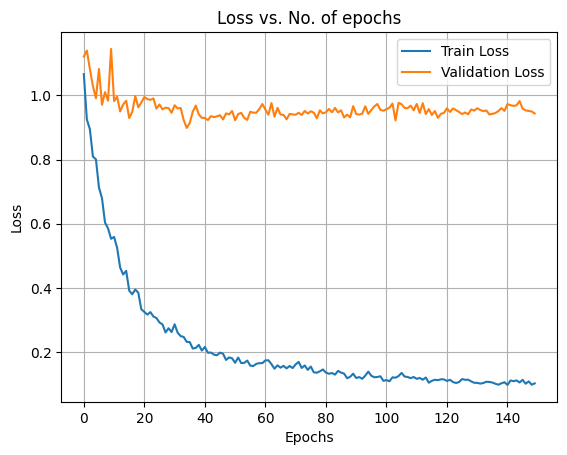

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [14]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [15]:
model = torch.load(f"/content/MOSI_Tensor_Fusion.pt").to(device)

test(
    model,
    test_dataloaders_all=testdata,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification",
)


<ipython-input-15-9740ca721ae0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'/content/MOSI_Tensor_Fusion.pt').to(device)


Recall: 73.0183% | Total Accuracy: 72.3032%
Inference Time: 371ms
Inference Params: 5488295
